In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from styling import *

In [2]:
# Read in FOA data from M7
FOA_df = pd.read_csv('./datasets/FOA data/FOAs GRS-BAE-data-2025-04-09 20_32_19.csv', usecols=[0,1])

# Remove 'm/s' from wind_m7 column
FOA_df['wind_m7'] = FOA_df['wind_m7'].str.replace(' m/s', '', regex=False).astype(float)

# Drop rows where "wind_m7" is NaN
FOA_df.dropna(subset=['wind_m7'], inplace=True)

# Convert timestamp column to actual datetime format (to avoid sorting issues)
FOA_df['Time'] = pd.to_datetime(FOA_df['Time'], errors='coerce')

# Adjust timestamps due to time zone issue
start_3h = pd.to_datetime("2024-10-17")
end_3h = pd.to_datetime("2024-10-27")
end_4h = pd.to_datetime("2025-03-30")

def shift_timestamps(ts):
    if start_3h <= ts < end_3h:
        return ts + pd.Timedelta(hours=3)
    elif end_3h <= ts < end_4h:
        return ts + pd.Timedelta(hours=4)
    else:
        return ts
    
FOA_df['Time'] = FOA_df['Time'].apply(shift_timestamps)
FOA_df.sort_values('Time', inplace=True)

In [3]:
# Read in Ammonit data

# Base directory where folders with CSV files are located
base_directory = './datasets/Ammonit data/'

# Empty list to store DataFrames
all_data = []

# Iterate through all files in the directory and subdirectories
for root, dirs, files in os.walk(base_directory):
    for file in files:
        # Check if the file is a CSV file
        if file.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(root, file)

            # Read CSV file with only the first two columns
            amm_df = pd.read_csv(file_path, usecols=[0, 1])

            # Convert first column to datetime
            amm_df.iloc[:, 0] = pd.to_datetime(amm_df.iloc[:, 0], errors='coerce')

            # Append the processed DataFrame to the list
            all_data.append(amm_df)

# Concatenate all DataFrames in the list into one massive DataFrame
Ammonit_df = pd.concat(all_data, ignore_index=True)
Ammonit_df.columns.values[1] = 'Wind speed'
Ammonit_df['datetime'] = pd.to_datetime(Ammonit_df['datetime'], errors='coerce')

# Drop rows where any column has missing values
Ammonit_df.dropna(inplace=True)

# Filter the DataFrame to remove rows where wind speed is < 0 or > 30
Ammonit_df = Ammonit_df[(Ammonit_df['Wind speed'] >= 0) & (Ammonit_df['Wind speed'] <= 30)]

# Sort by datetime column
Ammonit_df.sort_values(by='datetime', inplace=True)

# Reset index after sorting
Ammonit_df.reset_index(drop=True, inplace=True)


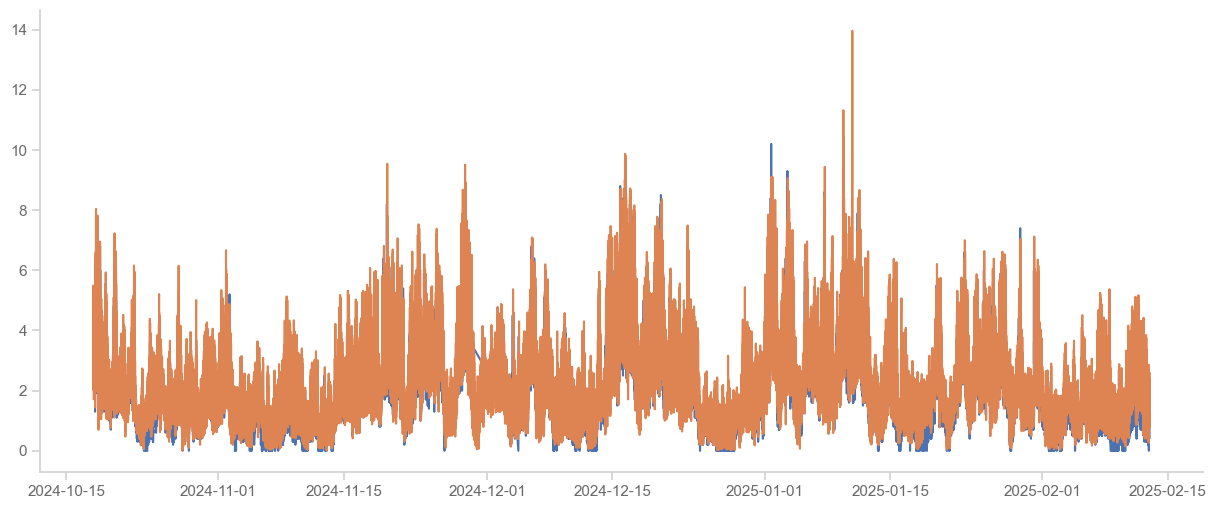

In [4]:
# Examine data after FOA installation (Oct 2024)

# Define the start and end dates
start_date = pd.to_datetime('2024-10-18')
end_date = pd.to_datetime('2025-02-13')

# Filter the dataframes for the date range to analyze
FOA_df = FOA_df[(FOA_df['Time'] >= start_date) & (FOA_df['Time'] <= end_date)]
FOA_df.reset_index(drop=True, inplace=True)
Ammonit_df = Ammonit_df[(Ammonit_df['datetime'] >= start_date) & (Ammonit_df['datetime'] <= end_date)]
Ammonit_df.reset_index(drop=True, inplace=True)

plt.figure(figsize=(15,6))
plt.plot(FOA_df['Time'], FOA_df['wind_m7'])
plt.plot(Ammonit_df['datetime'], Ammonit_df['Wind speed'])
plt.show()


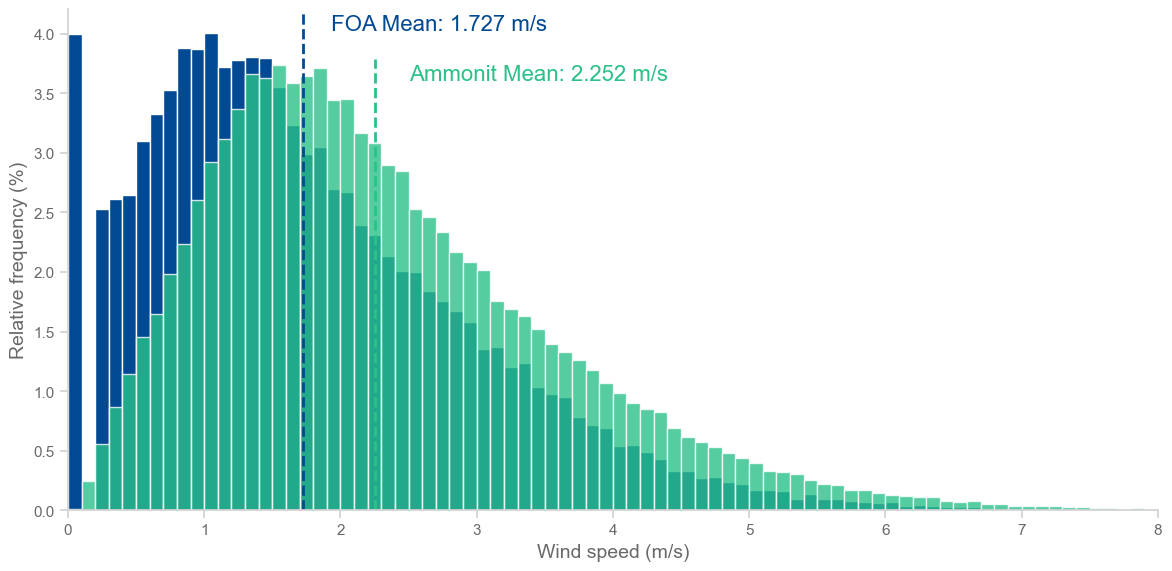

In [5]:
# Plot distribution of wind data

# Count occurrences of each wind speed value for both datasets
value_counts_foa = FOA_df['wind_m7'].value_counts().sort_index()

# Round Ammonit values to 1 decimal point 
# Need to use special rounding function to accomodate IEEE 754
from decimal import Decimal, ROUND_HALF_UP
value_counts_ammonit = Ammonit_df['Wind speed'].apply(
    lambda x: float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP))).value_counts().sort_index() 


# Convert to relative frequencies (percentages)
value_counts_foa_rel = value_counts_foa / len(FOA_df) * 100
value_counts_ammonit_rel = value_counts_ammonit / len(Ammonit_df) * 100




# Make histogram
plt.figure(figsize=(12,6))
plt.bar(value_counts_foa_rel.index, value_counts_foa_rel.values, color=C_PICOM, edgecolor='white', 
        align='edge', width=0.1,label='FOA')
plt.bar(value_counts_ammonit_rel.index, value_counts_ammonit_rel.values, color=C_GREEN, edgecolor='white',
        align='edge', width=0.1, alpha=0.8, label='Ammonit')

# Add vertical lines for mean
mean_foa = FOA_df['wind_m7'].mean()
mean_ammonit = Ammonit_df['Wind speed'].mean()
plt.axvline(x=mean_foa, color=C_PICOM, linestyle='--', linewidth=2, ymax=0.999)
plt.axvline(x=mean_ammonit, color=C_GREEN, linestyle='--', linewidth=2, ymax=0.9)

# Add mean value labels
plt.text(mean_foa + 1.0, plt.ylim()[1]*0.95, f'FOA Mean: {round(mean_foa, 3)} m/s', 
         color=C_PICOM, ha='center', va='bottom')
plt.text(mean_ammonit +1.2, plt.ylim()[1]*0.85, f'Ammonit Mean: {round(mean_ammonit, 3)} m/s', 
         color=C_GREEN, ha='center', va='bottom')


plt.xlabel('Wind speed (m/s)', fontsize=14)
plt.ylabel('Relative frequency (%)', fontsize=14)
plt.xlim(0.0, 8.0)

#plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Compute MAE

merged_df = pd.merge_asof(
    FOA_df,
    Ammonit_df,
    left_on='Time',
    right_on='datetime',
    direction='nearest',
    tolerance=pd.Timedelta(seconds=300)
)
merged_df['abs error'] = abs(merged_df['wind_m7'] - merged_df['Wind speed'])

MAE = merged_df['abs error'].mean()
print(f'MAE is {MAE}')

MAE is 0.7458591232856421
